In [1]:
import numpy as np 
import pandas as pd                                                            
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:

DATADIR = "/content/gdrive/MyDrive/ENPM809K/Cropped"
# Te_DATADIR = "Testing"
CT_Datadir = "/content/gdrive/MyDrive/ENPM809K/Cropped_test"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
# Te_CATEGORIES= ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
IMG_SIZE = 150


In [4]:
import plotly.express as px
classes_info = {}
classes = sorted(os.listdir(DATADIR))
for name in classes:
    classes_info[name] = len(os.listdir(DATADIR + f'/{name}'))
print(classes_info)
fig = px.pie(names=classes_info.keys(),values=classes_info.values(),hole=0.05,title='CLasses Info')
fig.update_layout({'title':{"x":0.1}})
fig.show()

{'glioma_tumor': 789, 'meningioma_tumor': 1319, 'no_tumor': 1446, 'pituitary_tumor': 1456}


In [5]:
glimoa_train = os.listdir("/content/gdrive/MyDrive/ENPM809K/Cropped/glioma_tumor")
men_train =  os.listdir("/content/gdrive/MyDrive/ENPM809K/Cropped/meningioma_tumor")
notumor_train = os.listdir("/content/gdrive/MyDrive/ENPM809K/Cropped/no_tumor")
pit_train =  os.listdir("/content/gdrive/MyDrive/ENPM809K/Cropped/pituitary_tumor")

In [6]:
# glimoa_test = os.listdir("Testing/glioma_tumor")
# men_test =  os.listdir("Testing/meningioma_tumor")
# notumor_test = os.listdir("Testing/no_tumor")
# pit_train =  os.listdir("Testing/pituitary_tumor")

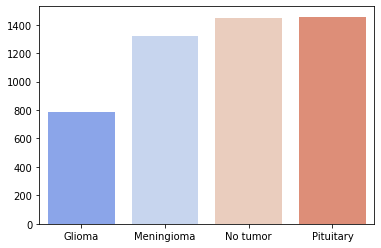

In [6]:
#picture in the  dataset
labels = ["Glioma", "Meningioma", "No tumor", "Pituitary"]
values = [len(glimoa_train), len(men_train), len(notumor_train), len(pit_train)]
sns.barplot(x = labels, y = values, palette="coolwarm")

In [7]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [8]:
cropped_test_data = []

def create_croppedtest_data():
    for category in CATEGORIES:
        path = os.path.join(CT_Datadir,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                cropped_test_data.append([new_array,class_num])
            except Exception as e:
                pass
create_croppedtest_data()

In [13]:
Xr = []
y = []
for features,label in training_data:
    Xr.append(features)
    y.append(label)
Xr = np.array(Xr).reshape(-1,IMG_SIZE,IMG_SIZE)
print(Xr.shape)
X = Xr/255.0  
X = X.reshape(-1,150,150,1)
print(X.shape)
print(Xr.shape)


(5010, 150, 150)
(5010, 150, 150, 1)
(5010, 150, 150)


In [10]:
Xce = []
yce = []
for features,label in cropped_test_data:
    Xce.append(features)
    yce.append(label)
Xce = np.array(Xce).reshape(-1,IMG_SIZE,IMG_SIZE)
print(Xce.shape)
Xce = Xce/255.0
Xce = Xce.reshape(-1,150,150,1)
print(Xce.shape)

(1251, 150, 150)
(1251, 150, 150, 1)


In [14]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y = to_categorical(y, num_classes = 4)
# ye = to_categorical(ye, num_classes = 4)
yce = to_categorical(yce, num_classes = 4)

# **Train/Val Split**

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)


x_train shape (4008, 150, 150, 1)
x_test shape (1002, 150, 150, 1)
y_train shape (4008, 4)
y_test shape (1002, 4)


In [16]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop ,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Activation

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)  

In [18]:
testgen = ImageDataGenerator(
        rescale=1./255)
testds = tf.keras.preprocessing.image_dataset_from_directory('/content/gdrive/MyDrive/ENPM809K/Cropped_test',
                                     image_size=(150,150),
                                     seed=123,
                                     batch_size  = 16,
                                     shuffle=False)

Found 1251 files belonging to 4 classes.


In [19]:

from tensorflow.keras import layers

**CNN 7x7**

In [21]:
from keras.layers import *
model = Sequential()
# 7 conv. & 7 maxpool
model.add(Conv2D(filters = 64, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
#model.add(Dropout(0.6))

#
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

#
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


#
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
#model.add(Dropout(0.5))

#

model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.5))

# 
model.add(Conv2D(filters = 512, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
#model.add(Dropout(0.5))

# #
# model.add(Conv2D(filters = 512, kernel_size = (2,2),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.5))
# model.add(BatchNormalization()) 
#
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr=5e-4, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 100
batch_size = 50

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [22]:
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size) 

Epoch 1/100


<ipython-input-22-9fece17c202d>:2: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



80/80 [==============================] - 15s 36ms/step - loss: 1.2096 - accuracy: 0.5685 - val_loss: 1.8058 - val_accuracy: 0.2924
Epoch 2/100
80/80 [==============================] - 2s 26ms/step - loss: 0.9364 - accuracy: 0.6529 - val_loss: 2.5097 - val_accuracy: 0.2924
Epoch 3/100
80/80 [==============================] - 2s 25ms/step - loss: 0.7951 - accuracy: 0.7031 - val_loss: 2.9492 - val_accuracy: 0.2924
Epoch 4/100
80/80 [==============================] - 2s 25ms/step - loss: 0.6800 - accuracy: 0.7509 - val_loss: 4.8060 - val_accuracy: 0.2934
Epoch 5/100
80/80 [==============================] - 2s 25ms/step - loss: 0.6114 - accuracy: 0.7774 - val_loss: 3.1114 - val_accuracy: 0.3074
Epoch 6/100
80/80 [==============================] - 2s 25ms/step - loss: 0.5499 - accuracy: 0.8027 - val_loss: 4.3473 - val_accuracy: 0.3613
Epoch 7/100
80/80 [==============================] - 2s 25ms/step - loss: 0.5282 - accuracy: 0.8034 - val_loss: 3.1067 - val_accuracy: 0.4481
Epoch 8/100
80/80

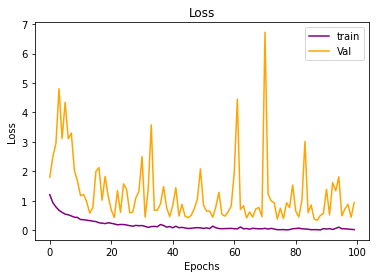

In [23]:
plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "Val"])
plt.show()

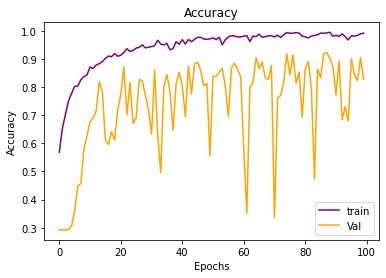

In [24]:
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "Val"])
plt.show()

In [25]:
model.save('/content/gdrive/MyDrive/ENPM809K/5layer60_w4.h5')


In [356]:
import tensorflow as tf
import numpy as np

# load the model from the .h5 file
model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENPM809K/5layer60_w3.h5')

# load the test dataset
test_data = Xce #np.load('test_data.npy')
test_labels = yce#np.load('test_labels.npy')
print(test_data.shape)
eval= model.evaluate(test_data, test_labels)[1]
# make predictions on the test dataset
predictions = model.predict(test_data)

# evaluate the model's performance
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(test_labels, predictions)
# print('Accuracy: %.2f' % accuracy.result().numpy())
print(eval,"eval")



(1251, 150, 150, 1)
40/40 [==============================] - 0s 5ms/step
0.769784152507782 eval


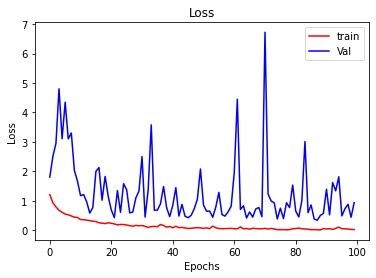

In [353]:
plt.plot(history.history["loss"],c = "red")
plt.plot(history.history["val_loss"],c = "blue")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "Val"])
plt.show()

**CNN TRAIN VALIDATION LOSS AND ACCURACY**

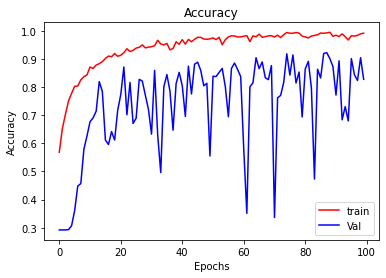

In [352]:
plt.plot(history.history["accuracy"],c = "red")
plt.plot(history.history["val_accuracy"],c = "blue")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "Val"])
plt.show()

In [29]:
#Saving weights
model.save_weights('/content/gdrive/MyDrive/ENPM809K/5layer60_weightsw4.h5')

In [30]:
def my_custom_func():
    # your code
    return
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/ENPM809K/5layer60_w4.h5', custom_objects={'my_custom_func':                   
my_custom_func})

In [31]:
import numpy as np
import matplotlib.pyplot as plt 
from keras.layers import Flatten, Dense 
from keras.models import Model, load_model 
from keras.applications.mobilenet import MobileNet

# **MOBILENET**

In [32]:
model_res =MobileNet(input_shape= (150,150,3),include_top=False)
model.load_weights('/content/gdrive/MyDrive/ENPM809K/5layer60_weightsw4.h5')

17225924/17225924 [==============================] - 2s 0us/step


In [33]:
for layer in model_res.layers:
  layer.trainable = False
X = Flatten () (model.output)
X = Dense(units=1 , activation= 'sigmoid') (X)
model1= Model(model.input, X)

In [49]:
import keras
optimizer = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999)
model_res.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['Accuracy'])

In [50]:
model_res.compile()
epochs = 60  
batch_size = 40

In [52]:
hist = model.fit_generator(datagen.flow(X_train,Y_train),steps_per_epoch=X_train.shape[0] // batch_size,epochs =80,validation_data = (X_val,Y_val),validation_steps=10)

Epoch 1/80


<ipython-input-52-841adf630f24>:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



100/100 [==============================] - 3s 18ms/step - loss: 0.0251 - accuracy: 0.9915 - val_loss: 0.4857 - val_accuracy: 0.9162
Epoch 2/80
100/100 [==============================] - 2s 17ms/step - loss: 0.0459 - accuracy: 0.9849 - val_loss: 0.6937 - val_accuracy: 0.8713
Epoch 3/80
100/100 [==============================] - 2s 17ms/step - loss: 0.0466 - accuracy: 0.9849 - val_loss: 0.7859 - val_accuracy: 0.8234
Epoch 4/80
100/100 [==============================] - 2s 17ms/step - loss: 0.0317 - accuracy: 0.9906 - val_loss: 0.4034 - val_accuracy: 0.9242
Epoch 5/80
100/100 [==============================] - 2s 17ms/step - loss: 0.0187 - accuracy: 0.9918 - val_loss: 0.4252 - val_accuracy: 0.9092
Epoch 6/80
100/100 [==============================] - 2s 17ms/step - loss: 0.0254 - accuracy: 0.9912 - val_loss: 0.6391 - val_accuracy: 0.8643
Epoch 7/80
100/100 [==============================] - 2s 17ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.5834 - val_accuracy: 0.8832
Epoch 8/80

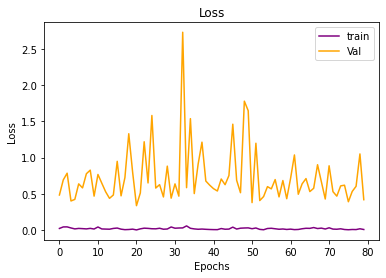

In [53]:
plt.plot(hist.history["loss"],c = "purple")
plt.plot(hist.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "Val"])
plt.show()

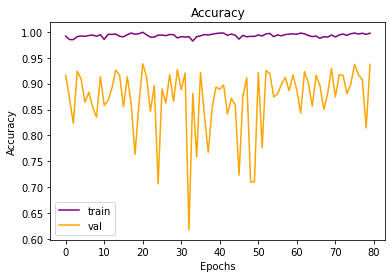

In [54]:
plt.plot(hist.history["accuracy"],c = "purple")
plt.plot(hist.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

In [55]:
model.save('/content/gdrive/MyDrive/ENPM809K/mobilenetw3.h5') #saving mobilenet weights

In [56]:
from keras import models    
m1=models.load_model('/content/gdrive/MyDrive/ENPM809K/mobilenetw3.h5')

In [57]:
import tensorflow as tf
import numpy as np

# load the model from the .h5 file
model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENPM809K/mobilenetw3.h5')

# load the test dataset
test_data = Xce #np.load('test_data.npy')
test_labels = yce#np.load('test_labels.npy')
print(test_data.shape)
print(test_labels.shape)
eval= model.evaluate(test_data, test_labels)
# make predictions on the test dataset
predictions = model.predict(test_data)

# evaluate the model's performance
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(test_labels, predictions)
# print('Accuracy: %.2f' % accuracy.result().numpy())
print(eval,"eval")




(1251, 150, 150, 1)
(1251, 4)
40/40 [==============================] - 0s 5ms/step
[1.74580979347229, 0.7897681593894958] eval


# **TESTING**

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
1/1 [==============================] - 0s 21ms/step
[[3.63864550e-10 1.06958926e-01 7.51836851e-08 8.93040955e-01]]
pituitary_tumor


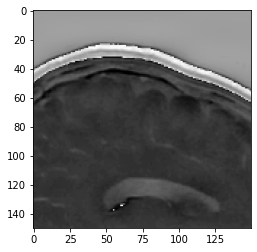

In [60]:
from keras.utils import load_img,img_to_array,array_to_img
import cv2

classnames=testds.class_names
print(classnames)
pred=model.predict(Xce[1091:1092])
print(pred)
oc=classnames[np.argmax(pred)]
print(oc)
from keras.utils import load_img,img_to_array,array_to_img

im=array_to_img(Xce[1092])
plt.imshow(im,cmap='gray_r')

In [1]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix

In [2]:
import seaborn as sns

In [3]:
y_test_arg=np.argmax(Y_val,axis=1)
Y_pred = np.argmax(model.predict(X_val),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
#annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

NameError: ignored

In [ ]:
predict_x=model.predict(X_val) 
classes_x=np.argmax(predict_x,axis=1)
classes_x

In [ ]:
Y_val2 = np.argmax(Y_val,axis=1)
Y_val2

In [373]:
from sklearn.metrics import classification_report

# **Resnet50**


In [139]:
def my_custom_func():
    return
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/ENPM809K/5layer60_w4.h5', custom_objects={'my_custom_func':                   
my_custom_func})

In [65]:
print(Xr.shape)  # (64, 224, 224)
Xr = np.repeat(Xr[..., np.newaxis], 3,-1)
print(Xr.shape)

(5010, 150, 150)
(5010, 150, 150, 3)


In [66]:
X_y, X_v, Y_y, Y_v = train_test_split(Xr, y, test_size = 0.2, random_state=42)
print("x_train shape",X_y.shape)
print("x_test shape",X_v.shape)
print("y_train shape",Y_y.shape)
print("y_test shape",Y_v.shape)

x_train shape (4008, 150, 150, 3)
x_test shape (1002, 150, 150, 3)
y_train shape (4008, 4)
y_test shape (1002, 4)


In [277]:
from keras.applications.resnet import *
rest_net=Sequential()
ptm=tf.keras.applications.ResNet50(include_top=False,input_shape=(150,150,3),pooling='avg',classes=4)
model.load_weights('/content/gdrive/MyDrive/ENPM809K/5layer60_weightsw4.h5')

In [278]:
for layer in model_res.layers:
  layer.trainable = False
rest_net.add(ptm)
rest_net.add(Flatten())
rest_net.add(Dense(512,activation='relu'))
rest_net.add(Dense(128,activation='relu'))
rest_net.add(Dense(4,activation='softmax'))


In [279]:
rest_net.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_17 (Flatten)        (None, 2048)              0         
                                                                 
 dense_50 (Dense)            (None, 512)               1049088   
                                                                 
 dense_51 (Dense)            (None, 128)               65664     
                                                                 
 dense_52 (Dense)            (None, 4)                 516       
                                                                 
Total params: 24,702,980
Trainable params: 24,649,860
Non-trainable params: 53,120
_________________________________________________________________


In [371]:
rest_net.compile(optimizer=Adam(lr=0.001,beta_1=0.9, beta_2=0.999),loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [372]:
epochs=40
batch_size=20
his=rest_net.fit(datagen.flow(X_y,Y_y),epochs=epochs,validation_data = (X_v,Y_v),validation_steps=20)

Epoch 1/40
126/126 [==============================] - 12s 54ms/step - loss: 0.6985 - accuracy: 0.7764 - val_loss: 1.9292 - val_accuracy: 0.5559
Epoch 2/40
126/126 [==============================] - 6s 46ms/step - loss: 0.3657 - accuracy: 0.8750 - val_loss: 15.7977 - val_accuracy: 0.2745
Epoch 3/40
126/126 [==============================] - 6s 46ms/step - loss: 0.2893 - accuracy: 0.9017 - val_loss: 0.9103 - val_accuracy: 0.6846
Epoch 4/40
126/126 [==============================] - 6s 46ms/step - loss: 0.2947 - accuracy: 0.8945 - val_loss: 1.9870 - val_accuracy: 0.4780
Epoch 5/40
126/126 [==============================] - 6s 46ms/step - loss: 0.2406 - accuracy: 0.9189 - val_loss: 1.5509 - val_accuracy: 0.6208
Epoch 6/40
126/126 [==============================] - 6s 46ms/step - loss: 0.2029 - accuracy: 0.9324 - val_loss: 0.4916 - val_accuracy: 0.8273
Epoch 7/40
126/126 [==============================] - 6s 46ms/step - loss: 0.1747 - accuracy: 0.9399 - val_loss: 2.5337 - val_accuracy: 0.66

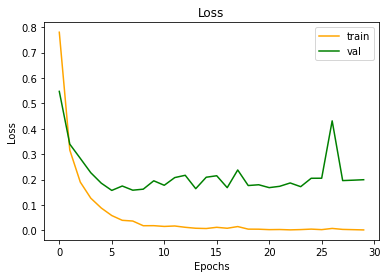

In [282]:
plt.plot(his.history["loss"],c = "orange")
plt.plot(his.history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

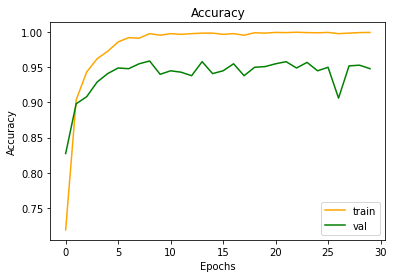

In [283]:
plt.plot(his.history["accuracy"],c = "orange")
plt.plot(his.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

In [377]:
model.save('/content/gdrive/MyDrive/ENPM809K/resnet50w5.h5')

In [378]:
from keras import models    
m2=models.load_model('/content/gdrive/MyDrive/ENPM809K/resnet50w5.h5')

In [379]:
import tensorflow as tf
import numpy as np

# load the model from the .h5 file
model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENPM809K/resnet50w5.h5')

# load the test dataset
test_data = Xce #np.load('test_data.npy')
test_labels = yce#np.load('test_labels.npy')
print(test_data.shape)
print(test_labels.shape)
eval= model.evaluate(test_data, test_labels)
# make predictions on the test dataset
predictions = model.predict(test_data)

# evaluate the model's performance
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(test_labels, predictions)
# print('Accuracy: %.2f' % accuracy.result().numpy())
print(eval,"eval")




(1251, 150, 150, 1)
(1251, 4)
40/40 [==============================] - 0s 4ms/step
[1.276041865348816, 0.769784152507782] eval


In [380]:
model.save_weights('/content/gdrive/MyDrive/ENPM809K/restnetweight50.h5')

# ResNet150


In [317]:
from keras.applications.resnet import *
rest_net1=Sequential()
ptm1=tf.keras.applications.ResNet152V2(include_top=False,input_shape=(150,150,3),pooling='avg',classes=4)
model.load_weights('/content/gdrive/MyDrive/ENPM809K/5layer60_weightsw4.h5')

In [318]:
for layer in model_res.layers:
  layer.trainable = False
rest_net1.add(ptm1)
rest_net1.add(Flatten())
rest_net1.add(Dense(512,activation='relu'))
rest_net1.add(Dense(256,activation='relu'))
rest_net1.add(Dense(128,activation='relu'))
rest_net1.add(Dense(64,activation='relu'))
rest_net1.add(Dense(4,activation='softmax'))

In [319]:
rest_net1.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 flatten_21 (Flatten)        (None, 2048)              0         
                                                                 
 dense_63 (Dense)            (None, 512)               1049088   
                                                                 
 dense_64 (Dense)            (None, 256)               131328    
                                                                 
 dense_65 (Dense)            (None, 128)               32896     
                                                                 
 dense_66 (Dense)            (None, 64)                8256      
                                                                 
 dense_67 (Dense)            (None, 4)               

In [342]:
rest_net1.compile(optimizer=Adam(lr=1e-3),loss='categorical_crossentropy',metrics=['accuracy'])


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [343]:
epochs=40
batch_size=20
his2=rest_net1.fit(datagen.flow(X_y,Y_y),epochs=epochs,validation_data = (X_v,Y_v),validation_steps=20)

Epoch 1/40
126/126 [==============================] - 31s 124ms/step - loss: 0.0350 - accuracy: 0.9915 - val_loss: 0.8261 - val_accuracy: 0.8912
Epoch 2/40
126/126 [==============================] - 13s 102ms/step - loss: 0.0106 - accuracy: 0.9968 - val_loss: 0.8734 - val_accuracy: 0.8982
Epoch 3/40
126/126 [==============================] - 13s 104ms/step - loss: 0.0118 - accuracy: 0.9970 - val_loss: 0.7957 - val_accuracy: 0.8822
Epoch 4/40
126/126 [==============================] - 13s 102ms/step - loss: 0.0462 - accuracy: 0.9910 - val_loss: 0.7574 - val_accuracy: 0.8962
Epoch 5/40
126/126 [==============================] - 13s 103ms/step - loss: 0.0121 - accuracy: 0.9965 - val_loss: 0.8871 - val_accuracy: 0.8703
Epoch 6/40
126/126 [==============================] - 13s 104ms/step - loss: 0.0321 - accuracy: 0.9895 - val_loss: 0.7676 - val_accuracy: 0.8693
Epoch 7/40
126/126 [==============================] - 13s 103ms/step - loss: 0.0244 - accuracy: 0.9928 - val_loss: 0.7028 - val_ac

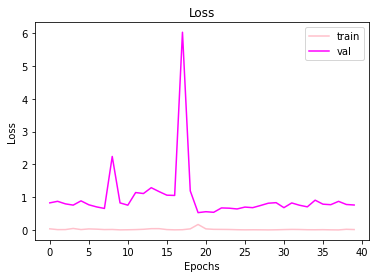

In [344]:
plt.plot(his2.history["loss"],c = "pink")
plt.plot(his2.history["val_loss"],c = "magenta")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

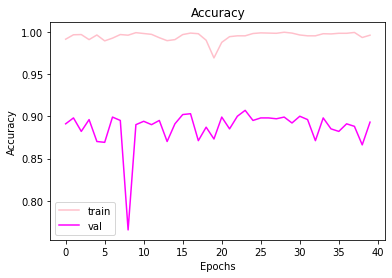

In [345]:
plt.plot(his2.history["accuracy"],c = "pink")
plt.plot(his2.history["val_accuracy"],c = "magenta")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

In [346]:
model.save('/content/gdrive/MyDrive/ENPM809K/ee1.h5')

In [347]:
from keras import models    
m2=models.load_model('/content/gdrive/MyDrive/ENPM809K/ee1.h5')

In [348]:
import tensorflow as tf
import numpy as np

# load the model from the .h5 file
model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENPM809K/ee1.h5')

# load the test dataset
test_data = Xce #np.load('test_data.npy')
test_labels = yce#np.load('test_labels.npy')
print(test_data.shape)
print(test_labels.shape)
eval= model.evaluate(test_data, test_labels)
# make predictions on the test dataset
predictions = model.predict(test_data)

# evaluate the model's performance
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(test_labels, predictions)
# print('Accuracy: %.2f' % accuracy.result().numpy())
print(eval,"eval")




(1251, 150, 150, 1)
(1251, 4)
40/40 [==============================] - 0s 5ms/step
[1.7722275257110596, 0.7162269949913025] eval


# **TRAIN ACCURACY COMPARISON BETWEEN CNN, MOBILENET, RESNET 50, RESNET 152**

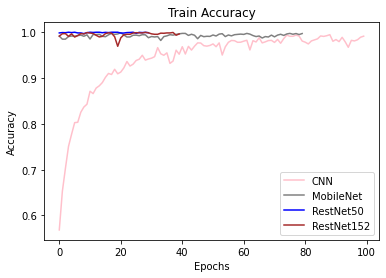

In [363]:
plt.plot(history.history["accuracy"],c = "pink")
plt.plot(hist.history["accuracy"],c = "Grey")
plt.plot(his.history["accuracy"],c = "blue")
plt.plot(his2.history["accuracy"],c = "brown")
plt.title("Train Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["CNN", "MobileNet","RestNet50","RestNet152"])
plt.show()

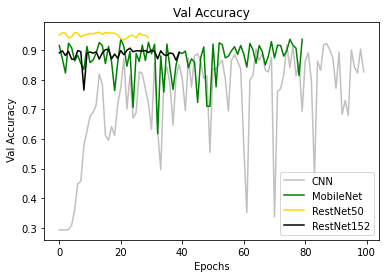

In [365]:
plt.plot(history.history["val_accuracy"],c = "silver")
plt.plot(hist.history["val_accuracy"],c = "green")
plt.plot(his.history["val_accuracy"],c = "gold")
plt.plot(his2.history["val_accuracy"],c = "black")
plt.title("Val Accuracy")
plt.ylabel(" Val Accuracy")
plt.xlabel("Epochs")
plt.legend(["CNN", "MobileNet","RestNet50","RestNet152"])
plt.show()